In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-annotation/aug_data/aug_data/val/labels/058401dd-9e97-11ee-810b-e3998be94514.42.json
/kaggle/input/face-annotation/aug_data/aug_data/val/images/058401dd-9e97-11ee-810b-e3998be94514.44.jpg
/kaggle/input/face-annotation/aug_data/aug_data/test/labels/0825ea9d-9e97-11ee-a9ce-e3998be94514.24.json
/kaggle/input/face-annotation/aug_data/aug_data/test/images/0682c6ec-9e97-11ee-8a23-e3998be94514.3.jpg
/kaggle/input/face-annotation/aug_data/aug_data/train/labels/072a72a0-9e97-11ee-9cbd-e3998be94514.22.json
/kaggle/input/face-annotation/aug_data/aug_data/train/images/0c91894e-9e97-11ee-ab8e-e3998be94514.41.jpg
/kaggle/input/face-annotation/data/labels/087b98d0-9e97-11ee-a009-e3998be94514.json
/kaggle/input/face-annotation/data/images/0a275f37-9e97-11ee-be6f-e3998be94514.jpg
/kaggle/input/face-annotation/data/val/labels/06306888-9e97-11ee-a2a1-e3998be94514.json
/kaggle/input/face-annotation/data/val/images/09280618-9e97-11ee-803f-e3998be94514.jpg
/kaggle/input/face-annotation/da

In [2]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.test.is_gpu_available()

True

In [5]:
images = tf.data.Dataset.list_files('/kaggle/input/face-annotation/data/images/*.jpg',shuffle=True)


In [6]:
images.as_numpy_iterator().next()

b'/kaggle/input/face-annotation/data/images/0b881a45-9e97-11ee-9d5e-e3998be94514.jpg'

In [7]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

In [9]:
image_generator = images.batch(4).as_numpy_iterator()

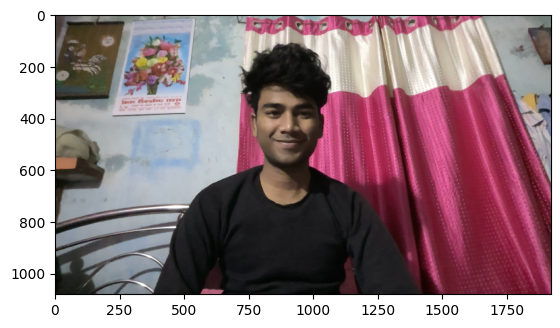

In [10]:
plt.imshow(image_generator.next()[0])

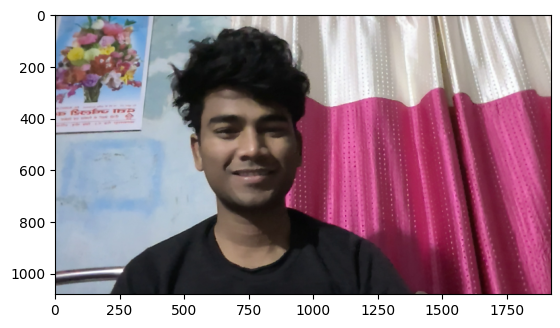

In [11]:
plt.imshow(images.as_numpy_iterator().next())

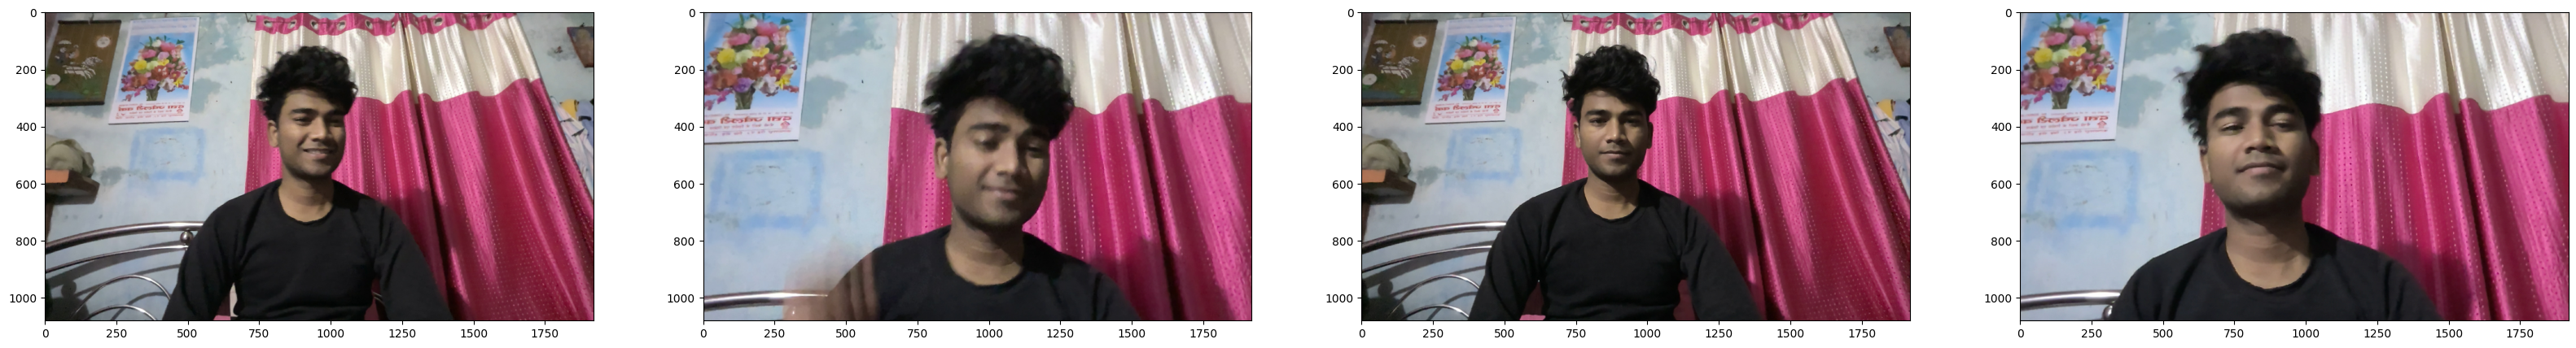

In [12]:
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(40,40))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [13]:
import albumentations as alb

In [14]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

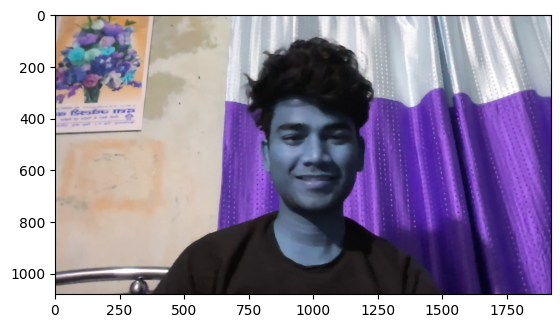

In [15]:
# /kaggle/input/face-annotation/data/train/images/0a7f6bb2-9e97-11ee-b7fe-e3998be94514.jpg
img = cv2.imread('/kaggle/input/face-annotation/data/train/images/0a7f6bb2-9e97-11ee-b7fe-e3998be94514.jpg')
plt.imshow(img)

In [16]:
# /kaggle/input/face-annotation/data/train/labels/0a7f6bb2-9e97-11ee-b7fe-e3998be94514.json
with open('/kaggle/input/face-annotation/data/train/labels/0a7f6bb2-9e97-11ee-b7fe-e3998be94514.json', 'r') as f:
    label = json.load(f)

In [17]:
label['shapes'][0]['points']

[[816.7073170731708, 321.7073170731707],
 [1176.4634146341461, 770.4878048780488]]

In [18]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [19]:
coords

[816.7073170731708, 321.7073170731707, 1176.4634146341461, 770.4878048780488]

In [20]:
h,w,d = img.shape

In [21]:
coords = list(np.divide(coords, [w,h,w,h]))

In [22]:
coords

[0.42536839430894313,
 0.29787714543812105,
 0.6127413617886178,
 0.7134146341463414]

In [41]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])


In [42]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [43]:
augmented['bboxes']

[(0.505636856368564, 0.0, 1.0, 0.936639566395664)]

In [44]:
augmented['image'].shape

(450, 450, 3)

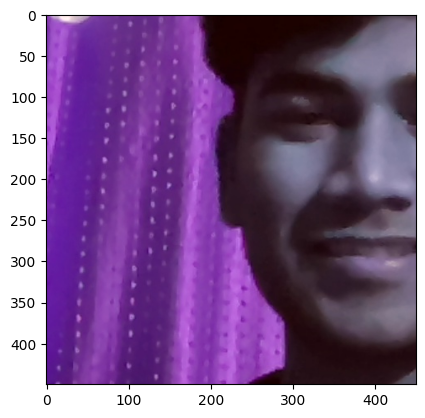

In [45]:
plt.imshow(augmented['image'])

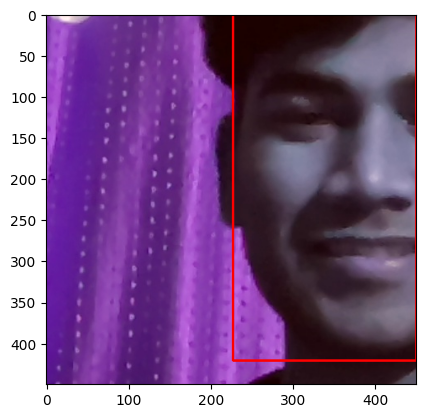

In [46]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [47]:
train_images = tf.data.Dataset.list_files('/kaggle/input/face-annotation/aug_data/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)

In [48]:
test_images = tf.data.Dataset.list_files('/kaggle/input/face-annotation/aug_data/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [49]:
val_images = tf.data.Dataset.list_files('/kaggle/input/face-annotation/aug_data/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

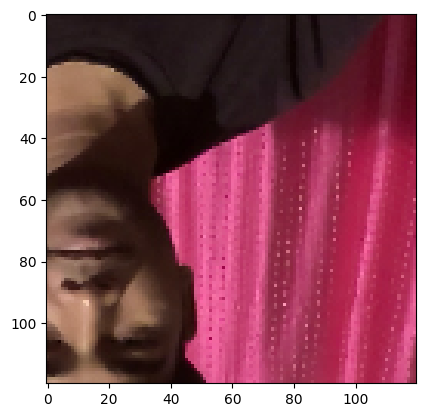

In [50]:
plt.imshow(train_images.as_numpy_iterator().next())

In [51]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [52]:
train_labels = tf.data.Dataset.list_files('/kaggle/input/face-annotation/aug_data/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
test_labels = tf.data.Dataset.list_files('/kaggle/input/face-annotation/aug_data/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [54]:
val_labels = tf.data.Dataset.list_files('/kaggle/input/face-annotation/aug_data/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1380, 1380, 180, 180, 180, 180)

In [56]:
 val_labels

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None))>

In [57]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [58]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [59]:
test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [60]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [61]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.4578, 0.829 , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.693 , 0.    , 1.    , 0.4814],
        [0.45  , 0.    , 1.    , 0.319 ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

In [62]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

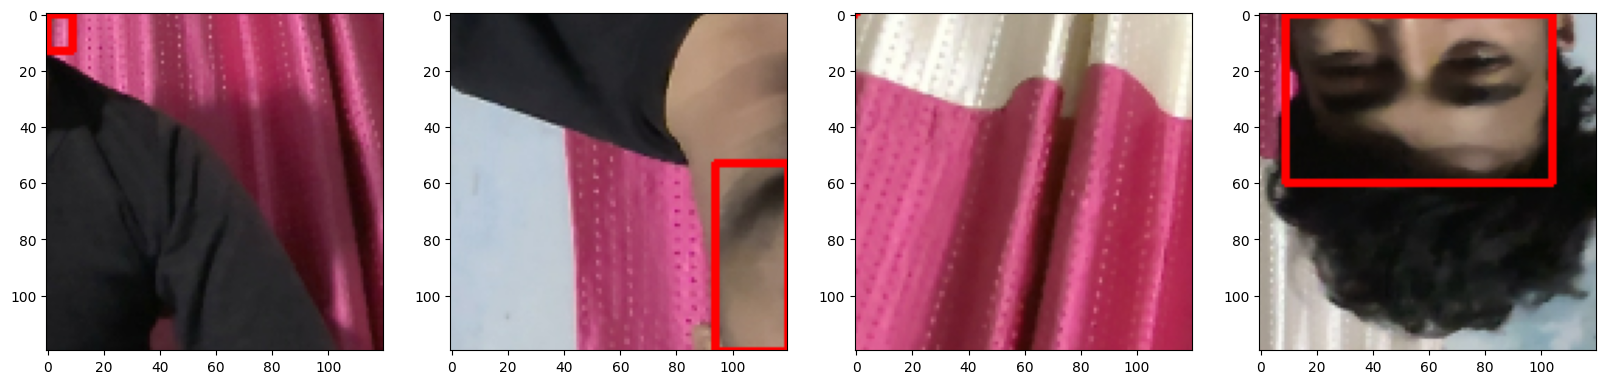

In [63]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [65]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [66]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [67]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [68]:
facetracker = build_model()

In [69]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [70]:
X, y = train.as_numpy_iterator().next()

In [71]:
X.shape

(8, 120, 120, 3)

In [72]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 7s 7s/step


In [73]:
classes, coords

(array([[0.7806382 ],
        [0.6241693 ],
        [0.6251909 ],
        [0.6522816 ],
        [0.59862125],
        [0.6293372 ],
        [0.7182437 ],
        [0.59235305]], dtype=float32),
 array([[0.831027  , 0.5015709 , 0.34308302, 0.4685366 ],
        [0.6359093 , 0.34799555, 0.39484772, 0.47953865],
        [0.6640978 , 0.36768627, 0.37155765, 0.43749782],
        [0.7691602 , 0.48751023, 0.38521343, 0.4788653 ],
        [0.7093003 , 0.31925055, 0.45762208, 0.4458551 ],
        [0.7086148 , 0.40948787, 0.31511652, 0.5156413 ],
        [0.68363404, 0.40911654, 0.23632053, 0.3588481 ],
        [0.6401622 , 0.3665211 , 0.3602841 , 0.4945753 ]], dtype=float32))

In [74]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [75]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)


In [76]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [77]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [79]:
localization_loss(y[1], coords).numpy()

7.1929245

In [81]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9583701>

In [82]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.1929245>

In [83]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [84]:
model = FaceTracker(facetracker)

In [85]:
model.compile(opt, classloss, regressloss)

In [86]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [87]:
hist = model.fit(train, epochs=100, validation_data=val,
                 callbacks=[tensorboard_callback])

Epoch 1/100
173/173 [==============================] - 18s 66ms/step - total_loss: 1.4379 - class_loss: 0.3254 - regress_loss: 1.2752 - val_total_loss: 0.2153 - val_class_loss: 0.0863 - val_regress_loss: 0.1721
Epoch 2/100
173/173 [==============================] - 12s 56ms/step - total_loss: 0.4883 - class_loss: 0.1239 - regress_loss: 0.4263 - val_total_loss: 0.2852 - val_class_loss: 0.3676 - val_regress_loss: 0.1014
Epoch 3/100
173/173 [==============================] - 12s 57ms/step - total_loss: 0.3206 - class_loss: 0.0916 - regress_loss: 0.2748 - val_total_loss: 0.0191 - val_class_loss: 0.0269 - val_regress_loss: 0.0057
Epoch 4/100
173/173 [==============================] - 12s 57ms/step - total_loss: 0.2283 - class_loss: 0.0716 - regress_loss: 0.1925 - val_total_loss: 0.0160 - val_class_loss: 0.0045 - val_regress_loss: 0.0137
Epoch 5/100
173/173 [==============================] - 12s 57ms/step - total_loss: 0.1459 - class_loss: 0.0445 - regress_loss: 0.1236 - val_total_loss: 0.01

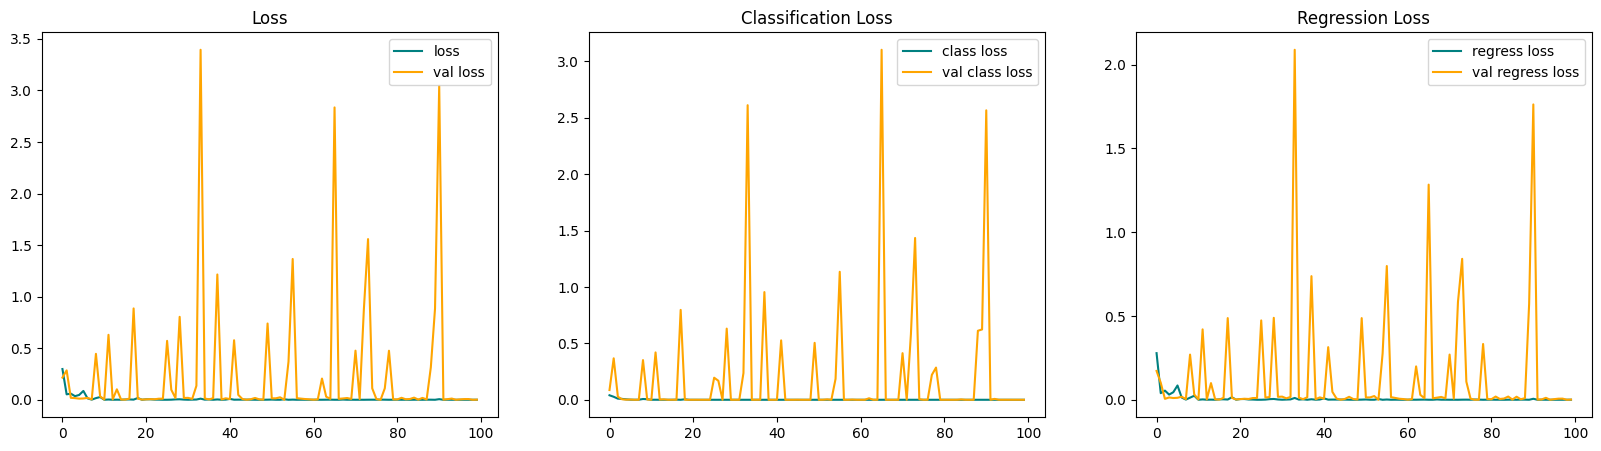

In [88]:
hist.history
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [89]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 21ms/step


In [90]:
yhat

[array([[5.54471853e-06],
        [2.18216289e-09],
        [1.03189475e-08],
        [1.00000000e+00],
        [7.78673100e-04],
        [1.00000000e+00],
        [2.36374722e-12],
        [9.99974728e-01]], dtype=float32),
 array([[3.0019560e-03, 4.0998845e-03, 4.3271091e-03, 5.1396987e-03],
        [4.7571782e-05, 1.9070631e-05, 1.0125220e-04, 6.9100948e-05],
        [9.7780379e-05, 1.5064035e-04, 2.1569734e-04, 2.3799989e-04],
        [8.7716633e-01, 2.8741306e-03, 9.9713182e-01, 5.5075091e-01],
        [5.1563708e-03, 3.0472730e-03, 1.6065430e-02, 6.8468219e-03],
        [9.1705072e-01, 5.1611817e-01, 9.9917656e-01, 9.9664044e-01],
        [8.8524052e-07, 1.8751840e-06, 2.3485547e-06, 7.3259562e-06],
        [5.0065893e-01, 8.4151846e-01, 9.4475424e-01, 9.8421282e-01]],
       dtype=float32)]

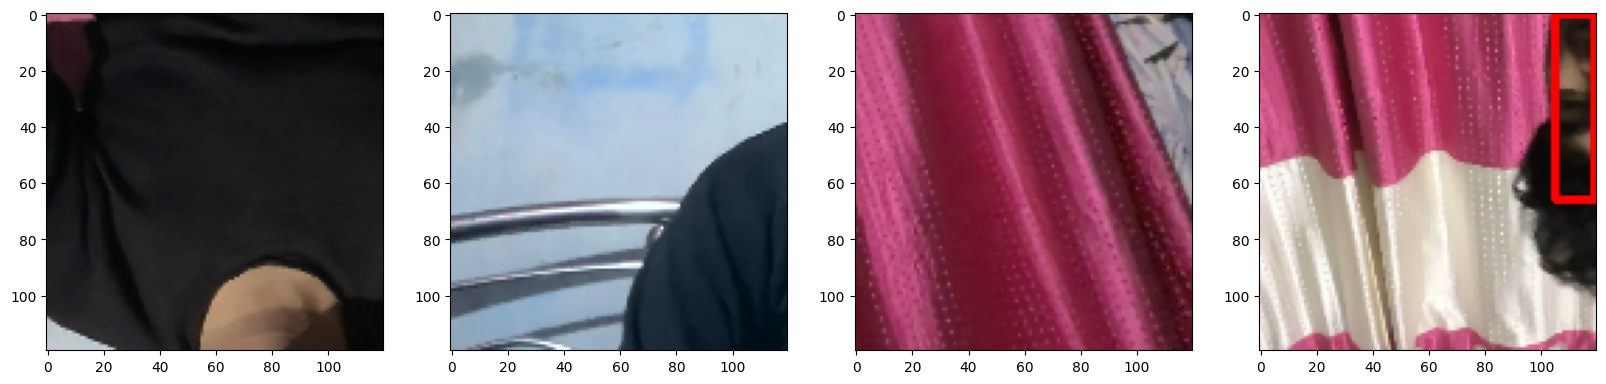

In [91]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [92]:
from tensorflow.keras.models import load_model

In [93]:
facetracker.save('facetracker.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
